## Реализация подсчёта треугольников

In [1]:
import graphblas as gb
import random

gb.init("suitesparse", blocking=False)

from graphblas.io import mmread
import numpy as np

In [2]:
rows = [0, 0, 1, 1, 1, 1, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6]
cols = [1, 3, 0, 3, 4, 6, 3, 5, 6, 0, 1, 2, 5, 6, 1, 5, 6, 2, 3, 4, 1, 2, 3, 4]
vals = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

A = gb.Matrix(gb.dtypes.INT32, nrows=max(rows) + 1, ncols=max(cols) + 1)

A.build(rows, cols, vals)
A

"M_0"      nvals  nrows  ncols  dtype         format
gb.Matrix     24      7      7  INT32  bitmapr (iso)
----------------------------------------------------
   0  1  2  3  4  5  6
0     1     1         
1  1        1  1     1
2           1     1  1
3  1  1  1        1  1
4     1           1  1
5        1  1  1      
6     1  1  1  1

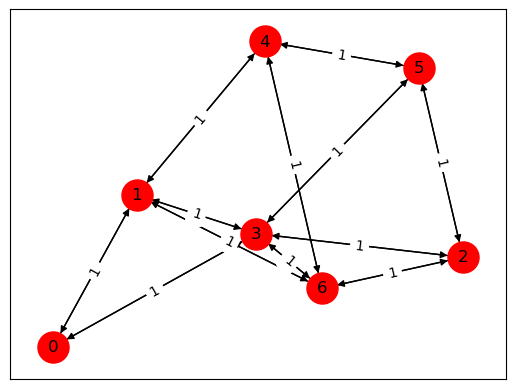

In [3]:
gb.viz.draw(A)

#### Наивный алгоритм

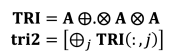

In [4]:
def naive(A):
    return int(A.mxm(A.mxm(A)).diag().reduce(gb.agg.sum).value or 0) / 6

naive(A)

5.0

#### Маскирование

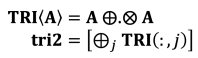

In [5]:
def naiveMask(A):
    return int(A.mxm(A).dup(mask=A.dup(dtype=gb.dtypes.BOOL)).reduce_scalar(gb.monoid.plus).value or 0) / 6

naiveMask(A)

5.0

#### Сohen's algorithm

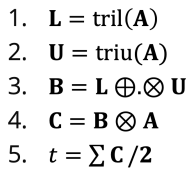

In [6]:
def cohen(A):
    L = gb.select.tril(A)
    U = gb.select.triu(A)
    B = L.mxm(U)
    mask = A.dup(dtype=gb.dtypes.BOOL)
    C = B.dup(mask=mask)
    return int(C.reduce_scalar(gb.monoid.plus).value or 0) / 2

cohen(A)

5.0

#### Sandia algorithm

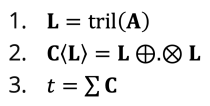

In [7]:
def sandia(A):
    L = gb.select.tril(A)
    C = L.mxm(L)
    mask = L.dup(dtype=gb.dtypes.BOOL)
    return C.dup(mask=mask).reduce_scalar(gb.monoid.plus).value or 0

sandia(A)

5

#### Функция, вычисляющая для каждой вершины кол-во треугольников, в которых она участвует

In [8]:
def triangles_for_each_vertex(A):
    return A.mxm(A.mxm(A)).diag().apply(lambda x: x // 2).new().ss.export()['values']

triangles_for_each_vertex(A)

array([1, 3, 2, 4, 1, 1, 3])

In [9]:
def test(A):
    result = [naive(A), naiveMask(A), cohen(A), sandia(A)]

    if not all(isinstance(element, (int, float)) for element in result):
        raise ValueError("Все значения должны быть числами")

    if not all(element == element for element in result):
        raise ValueError("Не все значения равны")

test(A)

 Скачаем 10 графов в формате ```Matrix Market``` с сайта [SuiteSparse Matrix Collection](https://sparse.tamu.edu/) (```Utherford-Boeing Type``` = ```Binary```, ```Special Structure``` = ```Symmetric```, ```Nonzeros.Min``` = ```10000```).

In [10]:
M1 = mmread('data/M1.mtx')
M2 = mmread('data/M2.mtx')
M3 = mmread('data/M3.mtx')
M4 = mmread('data/M4.mtx')
M5 = mmread('data/M5.mtx')
M6 = mmread('data/M6.mtx')
M7 = mmread('data/M7.mtx')
M8 = mmread('data/M8.mtx')
M9 = mmread('data/M9.mtx')
M10 = mmread('data/M10.mtx')

matrices = [M1, M2, M3, M4, M5, M6, M7, M8, M9, M10]

In [11]:
M7

"M_31"      nvals  nrows  ncols  dtype     format
gb.Matrix  104756   4704   4704   FP64  csr (iso)
-------------------------------------------------
     0    1    2    3    4    5    6    7    8    9     ... 4694 4695 4696  \
0     1.0  1.0                                          ...                  
1     1.0  1.0  1.0                                     ...                  
2          1.0  1.0  1.0                                ...                  
3               1.0  1.0  1.0                           ...                  
4                    1.0  1.0  1.0                      ...                  
...   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
4699                                                    ...  1.0       1.0   
4700                                                    ...       1.0        
4701                                                    ...  1.0       1.0   
4702                                                    ...       1.0        
4703                                                    ...       1.0        

     4697 4698 4699 4700 4701 4702 4703  
0                                        
1                                        
2                                        
3                                        
4                                        
...   ...  ...  ...  ...  ...  ...  ...  
4699            1.0       1.0            
4700  1.0  1.0       1.0       1.0  1.0  
4701            1.0       1.0            
4702  1.0  1.0       1.0       1.0  1.0  
4703  1.0  1.0       1.0       1.0  1.0

In [12]:
def algorithm_running_time(matrices):
    i = 1
    for matrix in matrices:
        print('Матрица №', i)
        print('Наивный алгоритм:', end=' ')
        %timeit naive(matrix)
        print('Наивный алгоритм с маской:', end=' ')
        %timeit naiveMask(matrix)
        print('Сohen\'s algorithm:', end=' ')
        %timeit cohen(matrix)
        print('Sandia algorithm:', end=' ')
        %timeit sandia(matrix)
        print('Кол-во треугольников для каждой вершины:', end=' ')
        %timeit triangles_for_each_vertex(matrix)
        print()
        i += 1

algorithm_running_time(matrices)

Матрица № 1
35.6 ms ± 2.48 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.12 ms ± 18.3 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.14 ms ± 17 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
1.04 ms ± 6.75 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
85.5 ms ± 774 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 2
7.74 ms ± 146 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.11 ms ± 54.7 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.4 ms ± 238 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
2.35 ms ± 108 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
63 ms ± 243 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 3
3.08 ms ± 102 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
750 μs ± 28.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
942 μs ± 23.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
567 μs ± 29.3 μs per loop (mean 

Sandia algorithm - самый быстрый алгоритм подсчета треугольников. Маскирование уменьшило время подсчета в 5-6 раз по сравнению с наивным алгоритмом.

In [13]:
def generate_random_undirected_graph(num_vertices, sparsity):

    graph = gb.Matrix(gb.dtypes.INT32, num_vertices, num_vertices)

    for i in range(num_vertices):
        for j in range(i + 1, num_vertices):
            if random.random() < sparsity:
                graph[i, j] = 1.0
                graph[j, i] = 1.0

    return graph

Генератор случайных неориентированных графов, в котором можно задавать количество вершин и степень разреженности графа.

In [14]:
matrix = generate_random_undirected_graph(10, 0.2)

matrix

"M_559379"  nvals  nrows  ncols  dtype         format
gb.Matrix      24     10     10  INT32  bitmapr (iso)
-----------------------------------------------------
   0  1  2  3  4  5  6  7  8  9
0           1                 1
1                    1     1   
2                       1     1
3  1           1  1            
4           1        1         
5           1        1         
6     1        1  1            
7        1                 1   
8     1                 1     1
9  1     1                 1

In [15]:
def generate_graphs(node_probs_list):
    return [generate_random_undirected_graph(nodes, prob) for nodes, prob in node_probs_list]

graph_specs = [
    (25, 0.2),
    (25, 0.5),
    (25, 0.9),
    (450, 0.2),
    (450, 0.5),
    (450, 0.9),
    (1500, 0.2),
    (1500, 0.5),
    (1500, 0.9)
]

matrices = generate_graphs(graph_specs)

In [16]:
algorithm_running_time(matrices)

Матрица № 1
206 μs ± 3.63 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
96.3 μs ± 1.45 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
180 μs ± 3.47 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
132 μs ± 3.53 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
55.9 ms ± 958 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 2
210 μs ± 4.02 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
121 μs ± 1.01 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
175 μs ± 1.17 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
128 μs ± 2.36 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
58.3 ms ± 955 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)

Матрица № 3
170 μs ± 728 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
110 μs ± 2.09 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
179 μs ± 1.67 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
131 μs ± 1

Для небольших графов время работы алгоритмов не сильно различается и не зависит от степени разреженности. При меньшей разреженности растет время работы алгоритмов.